### Import Tensorflow and other libraries


In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# —Preview TF 2.0 Alpha build with GPU support (unstable, Ubuntu and Windows)
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
# To generate GIFs
!pip install -q imageio

In [5]:
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
import imageio # Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. 
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
import os # This module provides a portable way of using operating system dependent functionality. 
import PIL # DescriptionPython Imaging Library is a free library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats.
import tensorflow.keras.layers as layers # Keras layers API
import time
from IPython import display # For displaying image

In [6]:
# Check if we're using a GPU device
# See what GPU we're using 
from tensorflow.python.client import device_lib

device_lib.list_local_devices()[-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16095310644
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3561769234177270522
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"

### Load and prepare the dataset
<p>We will use the MNIST dataset to train the gen and disc. </p>

In [7]:
# Files will be located in "/content/drive/My Drive"
import os

In [8]:
%cd storage/

/storage


In [9]:
# image location
image_directory = os.getcwd() + "/img_align_celeba/"

In [10]:
ls

image_at_epoch_0001.png  image_at_epoch_0021.png  image_at_epoch_0041.png
image_at_epoch_0002.png  image_at_epoch_0022.png  image_at_epoch_0042.png
image_at_epoch_0003.png  image_at_epoch_0023.png  image_at_epoch_0043.png
image_at_epoch_0004.png  image_at_epoch_0024.png  image_at_epoch_0044.png
image_at_epoch_0005.png  image_at_epoch_0025.png  image_at_epoch_0045.png
image_at_epoch_0006.png  image_at_epoch_0026.png  image_at_epoch_0046.png
image_at_epoch_0007.png  image_at_epoch_0027.png  image_at_epoch_0047.png
image_at_epoch_0008.png  image_at_epoch_0028.png  image_at_epoch_0048.png
image_at_epoch_0009.png  image_at_epoch_0029.png  image_at_epoch_0049.png
image_at_epoch_0010.png  image_at_epoch_0030.png  image_at_epoch_0050.png
image_at_epoch_0011.png  image_at_epoch_0031.png  images/
image_at_epoch_0012.png  image_at_epoch_0032.png  img_align_celeba/
image_at_epoch_0013.png  image_at_epoch_0033.png  img_align_celeba.zip
image_at_epoch_0014.png  image_at_epoch_0034.png  lost+found/
i

In [11]:
what = os.listdir(image_directory) # dir is your directory path
number_files = len(what)
print (number_files)

202599


In [12]:
# Helper function to load image
def load_image( infilename ) :
    img = PIL.Image.open( infilename )
    img = img.resize((64,64))
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [13]:
# load the celebA data
test = load_image(image_directory + "000034.jpg")

In [14]:
test.shape

(64, 64, 3)

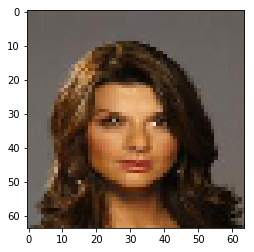

In [15]:
plt.imshow(test, interpolation='nearest')
plt.show()

In [16]:
files = os.listdir(image_directory)
train_images = []
for name in files:
    train_images.append(name)

In [17]:
# helper function to load images into an array
def load_images(file_names):
  data = []
  for name in file_names:
    data.append(load_image(image_directory + name))
  
  data = np.array(data)
  
  return data

In [18]:
# inspect the data real quick
test.shape # 218 x 178 x RGB

(64, 64, 3)

In [19]:
test[0][0]

array([99, 94, 90], dtype=int32)

In [20]:
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1). astype('float32') # puts each number in its own numpy array so instead of [1,2,3] gonna be [[1], [2], [3]]

In [21]:
#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1. 1] so if it was 0 --> -1 and if it was 255 --> 1

In [22]:
BUFFER_SIZE = 12800 # number of images in training i think
BATCH_SIZE = 128 # This is just the standard number for batch size. Google for more info

In [23]:
# Shuffle and Batch the data
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_images = np.array(train_images)
np.random.shuffle(train_images)
train_images = np.split(train_images[:BUFFER_SIZE],BATCH_SIZE)

### Create the models
<p>Both the generator and are definied using the Keras Sequential API</p>

In [24]:
!pip install -q pyyaml  # Required to save models in YAML format

In [69]:
def make_generator_model():
  # In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers
  model = tf.keras.Sequential()
  
  """
  Add a densely-connected layer to the model
  the model will take as input arrays of shape (*, 100).
  And and output arrays of shape (*, 7*7*256)
  
  after the first layer, you don't need to specify the size of the input anymore
  Afterwards, we do automatic shape inference
  """
  model.add(layers.Dense(4*4*1024, use_bias = False, input_shape = (100,)))
  
  """
  You can think about batch normalization as doing preprocessing at every layer of the network.
  Accelerating Deep Network Training by Reducing Internal Covariate Shift
  """
  model.add(layers.BatchNormalization())
  
  """
  ReLU is linear (identity) for all positive values, and zero for all negative values. 
  Leaky ReLU has a small slope for negative values, instead of altogether zero. For example, leaky ReLU may have y = 0.01x when x < 0
  """
  model.add(layers.LeakyReLU())
  
  # reshape the output from something flattened to something with a shape of (7,7,256)
  model.add(layers.Reshape(( 4, 4, 1024)))
  #print(model.output_shape)
  #print("here 1")
  assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size
  
  """
  The generator uses a transposed convolutional layer (Upsampling) layers to produce an image from seed (random noise).
  
  128 is the dimensionality of the output space
  (5,5) specifies the height and width of the 2D convolution window
  strides = (1,1) specifies the strides of the convolution along the height and width 
  
  """
  model.add(layers.Conv2DTranspose(512, (5, 5), strides = (2,2), padding = "same", use_bias = False))
  #print(model.output_shape)
  #print("here2")
  assert model.output_shape == (None, 8, 8, 512)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Another transposed convolutional layer (upsampling)
  #print("here3")
  model.add(layers.Conv2DTranspose(256, (5,5), strides = (2,2), padding = "same", use_bias = False))
  #print("here4")
  assert model.output_shape == (None, 16, 16, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Another transposed convolutional layer (upsampling)
  #print("here4")
  model.add(layers.Conv2DTranspose(128, (5,5), strides = (2,2), padding = "same", use_bias = False))
  #print("here5")
  assert model.output_shape == (None, 32, 32, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  # Final output layer also a convolutional layer (upsampling), tanh goes from -1 to 1
  #print("here6")
  model.add(layers.Conv2DTranspose(3, (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))
  #print("here7")

  
  print(model.output_shape)
  assert model.output_shape == (None, 64, 64, 3)
  
  
  return model

### Use the untrained generator to create an image

(None, 64, 64, 3)


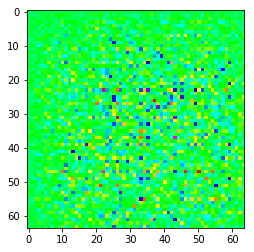

In [26]:
generator = make_generator_model()

noise = tf.random.normal([1,100]) # shape is 1, 100
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap ="gist_rainbow")

In [27]:
type(generated_image[0, :, :, 0])

tensorflow.python.framework.ops.EagerTensor

### The Discriminator


In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
      
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    """
    Flattens the input. Does not affect the batch size.
    If inputs are shaped (batch,) without a channel dimension, then flattening adds an extra channel dimension and output shapes are (batch, 1).
    """
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model

### Use the untrained discriminator to classify the generated images as real or fake. 
<p>The model will be trained to output positive values for real images, and negative values for fake images.</p>

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[5.5305376e-05]], shape=(1, 1), dtype=float32)


### Define the Loss and Optimizers for both models

In [30]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [31]:
"""
Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predicitions on real images to an array of 1s
and the dicriminator's predicitons on fake (generated) images to an array of 0s.
"""
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  
  return total_loss

In [32]:
"""
Generator Loss

The generator's loss quantifies how well it was able to trick the discrimator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
Here, we will compare the discriminators decisions on the generated images to an array of 1s.
"""
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
"""
The discriminator and the generator optimizers are different since we will train two networks separately.
The Adam optimization algorithm is an extension to stochastic gradient descent.
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
<p>Demonstrates how to save and restore models</p>

In [34]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [53]:
type(generator)

tensorflow.python.keras.engine.sequential.Sequential

In [55]:
##*****save generator
generator.save_weights('./training_checkpoints/md')

In [56]:
generator1  = make_generator_model()
generator1.load_weights('./training_checkpoints/md')

(None, 64, 64, 3)


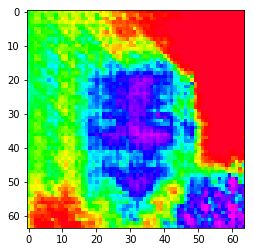

In [85]:
noise = tf.random.normal([1,100]) # shape is 1, 100
generated_image = generator1(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap ="gist_rainbow")

### Define the training loop

In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 8

# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
"""
The training loop begins with generator receiving a random seed as input. 
That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
"""

# Notice the use of tf.function
# This annotation causes the function to be "compiled"
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # take the image links and return a cropped image
    new_images = []
    #print("here1 ...")
    i = 0 
    for file_name in images:
        print(i)
        #print("Hey here")
        print(file_name)
        i+=1
        new_pic = load_image(image_directory + file_name)
        #print("ok")
        new_images.append(new_pic)
        #print("now what")
    
    #print("here 2")
    images = np.array(new_images)
    #print("reconfiguring complete")
    # Do some reshaping
    images = images.reshape(images.shape[0], 64, 64, 3).astype('float32') # puts each number in its own numpy array so instead of [1,2,3] gonna be [[1], [2], [3]]
    #print("here 3")
    images = (images - 127.5) / 127.5 # Normalize the images to [-1. 1] so if it was 0 --> -1 and if it was 255 --> 1
    print("Normalized the data")
    """
GradientTape() Records operations for automatic differentiation. Operations are recorded if 
they are executed within this context manager and at least one of their inputs is being "watched".
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # free memory!
    images = None

In [37]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      #print(image_batch)
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [38]:
image_directory

'/storage/img_align_celeba/'

### Generate and Save the images


In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch), cmap ="gist_rainbow")
  plt.show()

### Train the model
<p>
  Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.
  </p>

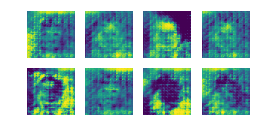

CPU times: user 36min 11s, sys: 2min 43s, total: 38min 54s
Wall time: 1h 5min 39s


In [40]:
%%time
train(train_images, EPOCHS)

### Restore the last checkpoint

In [41]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Create a Gif

In [42]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

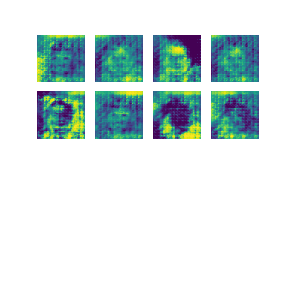

In [43]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [44]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('dcgan.gif', 'dcgan.gif.png')

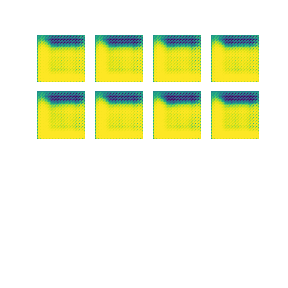

In [45]:
display.Image(filename="dcgan.gif.png")